# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [86]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass
from scipy.optimize import curve_fit

In [87]:
# Group Constants
MALE = 'male'
FEMALE = 'female'
SEX_CATEGORIES = [MALE, FEMALE]

# Intervention Constants
CONTROL_GROUP = 'None'
ALL_GROUP = 'All'
ONE_REMOVED_PREFIX = 'no_'

# Dataset Contsants
DATASET_DIRECTORY = os.path.join('..', 'dat', 'RMR_data')

# Graphing constants
COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]

### Parsing the data
In this section we take the extracted values of the robust mouse rejuvination study and wrangle the data into the format needed for modeling the data.

In [88]:
dataset_paths = os.listdir(DATASET_DIRECTORY)

def convert_filename_to_key(filename, category):
    category_removed = filename[len(category) + 1:]
    return os.path.splitext(category_removed)[0]

def create_dataset_mapping(dataset_directory, categories):
    dataset_mappings = {}
    
    for category in categories:
        category_path = {} 
        for path in dataset_paths:
            full_path = os.path.join(dataset_directory, path)
    
            if category == path[:len(category)]:
                key = convert_filename_to_key(path, category)
                category_path[key] = full_path
        dataset_mappings[category] = category_path
    
    return dataset_mappings

In [89]:
def is_one_removed_intervention(key):
    if len(key) < 3:
        return False

    return key[:len(ONE_REMOVED_PREFIX)] == ONE_REMOVED_PREFIX

def extract_single_interventions(dataset_mapping: dict):
    single_interventions = []
    for key in dataset_mapping.keys():
        if key == ALL_GROUP:
            continue
        elif key == CONTROL_GROUP:
            continue
        elif is_one_removed_intervention(key):
            continue
        else:
            single_interventions.append(key)
    
    return single_interventions

def create_one_removed_key(key: str, intervention_list: []) -> []:
    removed_key = key[len(ONE_REMOVED_PREFIX):]

    removed_intervention_list = []
    for intervention in intervention_list:
        if intervention != removed_key:
            removed_intervention_list.append(intervention)

    return removed_intervention_list

def create_intervention_list_from_group(key: str, intervention_list: []):
    new_intervention_list = None
    
    if key == ALL_GROUP:
        new_intervention_list = intervention_list
    elif key == CONTROL_GROUP:
        new_intervention_list = []
    elif is_one_removed_intervention(key):
        new_intervention_list = create_one_removed_key(key, intervention_list)
    else:
        new_intervention_list = [key]

    return ','.join(new_intervention_list)

In [90]:
def load_csv(path):
    return pd.read_csv(
                        path,
                        skiprows=0,
                        sep=',',
                        engine='python',
                        decimal='.',
                        dtype={'x': 'float64', 'y': 'float64'}
            )


def create_dataset_by_category(category_path: dict, single_interventions: []):
    datasets = {}
    for key, path in category_path.items():
        new_key = create_intervention_list_from_group(key, single_interventions)
        datasets[new_key] = load_csv(path)
    return datasets

dataset_mapping = create_dataset_mapping(DATASET_DIRECTORY, SEX_CATEGORIES)
female_dataset_paths = dataset_mapping[FEMALE]
female_single_interventions = extract_single_interventions(female_dataset_paths)

female_dataset = create_dataset_by_category(female_dataset_paths, female_single_interventions)

In [91]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


DEFAULT_INITIAL_PARAMETERS = GompertzParameters(alpha=0.1, beta=0.085)

def fit_gompertz_model(ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       initial_parameters: GompertzParameters = DEFAULT_INITIAL_PARAMETERS,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

test_dataset = female_dataset['HSCs']

def calculate_ages(dataset):
    return np.array(dataset.x) / 365 # ages in years

def calculate_mortality_rate(dataset):
    return np.array(1 - dataset.y)

def fit(dataset):
    ages = calculate_ages(dataset)
    mortality_rate = calculate_mortality_rate(dataset)
    
    predicted_parameters = fit_gompertz_model(ages, mortality_rate)
    predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)
    return predicted_mortality

In [92]:
def plot_fitted_gompertz_curve(ages, mortality_rate, all_mortality_rate, single_mortality_rate, title: str) -> None:
    plt.scatter(ages, mortality_rate, label='Observed Data', color=COLOR_MAP[0])
    plt.plot(ages, predicted_mortality, label='All Gompertz Fit', color=COLOR_MAP[1])
    plt.plot(ages, single_mortality_rate, label='Single Gompertz Fit', color=COLOR_MAP[2])
    plt.xlabel('Age of Mice (Years)')
    plt.ylabel(f'Mortality Rate ({title})')
    plt.legend()
    plt.show()

# Multi-Layer Perceptron

In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.softpluts = nn.Softplus()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.elu(x)
        x = self.fc2(x)
        return x

class MortalityDataset(Dataset):
    def __init__(self, data_dict, samples):
        self.samples = samples

        for treatment_key, treatment_data in data_dict.items():
            age_values = treatment_data['x'].values
            mortality_rates = 1 - treatment_data['y'].values
            treatment_vector = self.create_treatment_vector(treatment_key)

            for age, mortality_rate in zip(age_values, mortality_rates):
                sample = {
                    'input': torch.tensor([age] + treatment_vector, dtype=torch.float32),
                    'output': torch.tensor([mortality_rate], dtype=torch.float32)
                }
                self.samples.append(sample)

    def create_treatment_vector(self, treatment_key):
        # Create a binary treatment vector for each treatment
        all_treatments = ['Rapamycin', 'HSCs', 'Gal-Nav', 'mTERT']
        treatment_vector = [1 if t in treatment_key else 0 for t in all_treatments]
        return treatment_vector

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Create the dataset
mortality_dataset = MortalityDataset(data_dict = female_dataset, samples = [])

# Create a DataLoader without batching as the data isnt too big
data_loader = DataLoader(mortality_dataset, batch_size=len(mortality_dataset), shuffle=True)

In [228]:
from sklearn.model_selection import train_test_split

# Model parameters
input_size = 5  # Age + Treatment vector size
hidden_size = 64
output_size = 1
learning_rate = 0.01
num_epochs = 10000
torch.manual_seed(42)

# Initialize model, loss function, and optimizer
model = MLPModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(mortality_dataset.samples, test_size=0.2, random_state=42)

# Create separate datasets for training and validation
train_dataset = MortalityDataset(data_dict= {},samples=train_data)
val_dataset = MortalityDataset(data_dict= {},samples=val_data)

# Create separate DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

# Training loop
best_val_loss = float('inf')  # Initialize with a large value
best_model = None
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch in train_loader:
        inputs = batch['input']
        outputs = batch['output']

        # Forward pass
        predictions = model(inputs)
        # Compute loss
        loss = criterion(predictions, outputs)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    with torch.no_grad():
        val_loss = 0.0
        for val_batch in val_loader:
            val_inputs = val_batch['input']
            val_targets = val_batch['output']

            val_predictions = model(val_inputs)
            val_loss += criterion(val_predictions, val_targets)

    # Calculate average validation loss
    val_loss /= len(val_loader)

    # Print the loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    # Check if the current model has the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()

# Use the best model for inference
model.load_state_dict(best_model)

Epoch 1/10000, Loss: 1903.534423828125, Val Loss: 3266.474609375
Epoch 2/10000, Loss: 3219.50537109375, Val Loss: 1103.5322265625
Epoch 3/10000, Loss: 1087.8018798828125, Val Loss: 0.4597797393798828
Epoch 4/10000, Loss: 0.46387648582458496, Val Loss: 502.3651123046875
Epoch 5/10000, Loss: 494.9070739746094, Val Loss: 910.2061767578125
Epoch 6/10000, Loss: 896.7913818359375, Val Loss: 672.0414428710938
Epoch 7/10000, Loss: 662.1339721679688, Val Loss: 242.45274353027344
Epoch 8/10000, Loss: 238.8577423095703, Val Loss: 13.30297565460205
Epoch 9/10000, Loss: 13.100321769714355, Val Loss: 46.60527420043945
Epoch 10/10000, Loss: 45.95763397216797, Val Loss: 197.94671630859375
Epoch 11/10000, Loss: 195.11898803710938, Val Loss: 303.9613037109375
Epoch 12/10000, Loss: 299.59735107421875, Val Loss: 294.5419921875
Epoch 13/10000, Loss: 290.30963134765625, Val Loss: 194.0192108154297
Epoch 14/10000, Loss: 191.22657775878906, Val Loss: 76.83390808105469
Epoch 15/10000, Loss: 75.73265075683594, 

<All keys matched successfully>

In [261]:
def plot_model_results(model, age, treatment, ax=None):
    predictions = make_predictions(model, age, treatment)
    ages_plot = age / 365

    # Check if an axis is provided, if not, create a new subplot
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the predicted mortality rates
    ax.scatter(ages_plot, predictions, label='Predicted Mortality Rate', color=COLOR_MAP[0])
    ax.set_xlabel('Age of Mice (Years)')
    ax.set_ylabel('Predicted Mortality Rate')
    ax.set_title('Predicted Mortality Rates for Treatment Combination ' + str(treatment))
    ax.legend()

    # If an axis was created inside the function, show the plot
    if ax is None:
        plt.show()
        
def make_predictions(model, ages, treatment):
    input_data = []
    for age in ages:
        treatment_vector = treatment
        sample = {
            'input': torch.tensor([age] + treatment_vector, dtype=torch.float32),
        }
        input_data.append(sample)
    
    # Convert input_data to a DataLoader for batch processing
    prediction_data_loader = DataLoader(input_data, batch_size=len(input_data), shuffle=False)
    # Set the model to evaluation mode
    model.eval()
        
    # Make predictions
    predictions = []
    with torch.no_grad():
        for batch in prediction_data_loader:
            inputs = batch['input']
            output = model(inputs)
            predictions.extend(output.squeeze().tolist())
    return predictions


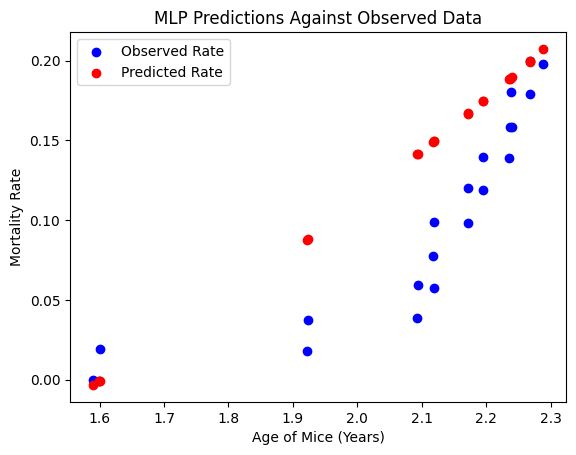

In [257]:
## Model against Observed

ages_plot = calculate_ages(female_dataset["mTERT,Rapamycin,HSCs,Gal-Nav"])
mortality_rate = calculate_mortality_rate(female_dataset["mTERT,Rapamycin,HSCs,Gal-Nav"])

mr_predictions = make_predictions(model, female_dataset["mTERT,Rapamycin,HSCs,Gal-Nav"]["x"], [1,1,1,1])

plt.scatter(ages_plot, mortality_rate, label='Observed Rate', color='blue')
plt.scatter(ages_plot, mr_predictions, label='Predicted Rate', color='red')

plt.xlabel('Age of Mice (Years)')
plt.ylabel('Mortality Rate')
plt.title('MLP Predictions Against Observed Data')
plt.legend()
plt.show()


In [ ]:
# Plot all the combos

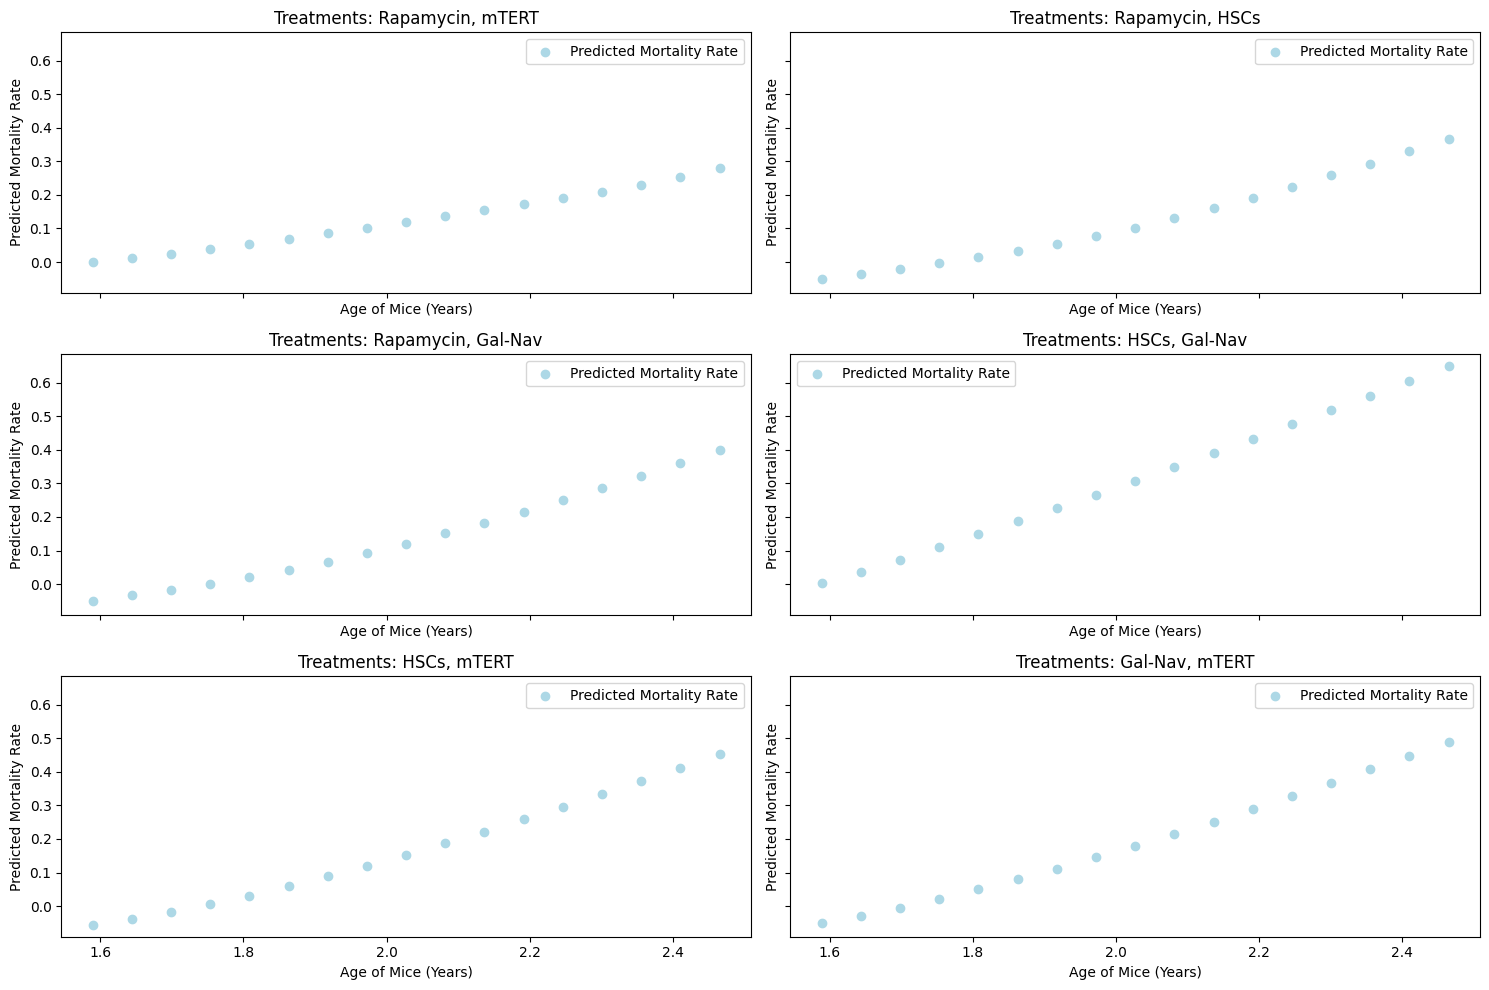

In [262]:
all_combos = [[1, 0, 0, 1], [1, 1, 0, 0], [1, 0, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1]]
ages_to_predict = np.arange(580, 901, 20)

# Define the number of rows and columns for the subplot grid
num_rows = 3  # You can adjust this based on your preference
num_cols = 2

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10),sharex=True, sharey=True)
# Flatten the axs array to make it easier to iterate over
axs = axs.flatten()
# Treatment labels
treatment_labels = ['Rapamycin', 'HSCs', 'Gal-Nav', 'mTERT']

# Iterate through each treatment combination and plot the results in a subplot
for i, treatments in enumerate(all_combos):
    # Select the current subplot
    ax = axs[i]

    # Plot the model results in the current subplot
    plot_model_results(model, ages_to_predict, treatments, ax=ax)

    # Add a title for better identification of each subplot
    ax.set_title(f'Treatments: {", ".join([treatment_labels[i] for i in range(len(treatments)) if treatments[i] == 1])}')


# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()